<a href="https://colab.research.google.com/github/asia281/VisualRecognition2024/blob/main/Asia_of_Lab_3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

Task: Implement and train a probabilistic AutoEncoder called Variational AutoEncoder (VAE) on MNIST. A nice introduction to this topic is [here](https://www.jeremyjordan.me/variational-autoencoders/).

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cuda = True
device = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 0.001

epochs = 10

In [3]:
dataset_path = 'datasets'
mnist_transform = torchvision.transforms.Compose([ torchvision.transforms.ToTensor() ])
train_dataset = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 93039887.85it/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108739402.00it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 37903395.23it/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20396711.74it/s]


Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [20]:
# Implement Encoder that consists of FC input_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> latent_dim
# You can use LeakyReLU 0.2

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.LeakyReLU(0.2),

          nn.Linear(hidden_dim, hidden_dim),
          nn.LeakyReLU(0.2),
        )
        self.fc_mean = nn.Sequential(
          nn.Linear(hidden_dim, latent_dim),
          nn.LeakyReLU(0.2),
        )
        self.fc_var = nn.Sequential(
          nn.Linear(hidden_dim, latent_dim),
          nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.encoder(x)
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        return mean, log_var


In [13]:
# Implement Decoder that consists of FC latent_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> output_dim
# You can use Sigmoid and LeakyReLU 0.2

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
          nn.Linear(latent_dim, hidden_dim),
          nn.LeakyReLU(0.2),

          nn.Linear(hidden_dim, hidden_dim),
          nn.LeakyReLU(0.2),

          nn.Linear(hidden_dim, output_dim),
          nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [28]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, log_var):
        # TODO: implement reparameterization
        std = torch.exp(0.5 * log_var)
        eps = torch.rand_like(std)
        return mean + eps * std

    def forward(self, x):
        # TODO: implement forward function that uses reparameterization function
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [30]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [32]:
# Loss function for the Gaussian distribution prior is presented in https://arxiv.org/pdf/1907.08956.pdf, Eq. 43.

def loss_function(x, x_hat, mean, log_var):
    rec_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # KL Divergence term
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return rec_loss + KLD

In [33]:
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "Average Loss: ", overall_loss / (len(train_loader) * batch_size))

	Epoch 1 Average Loss:  170.33802454427084
	Epoch 2 Average Loss:  114.79928748372396
	Epoch 3 Average Loss:  101.12907097981771
	Epoch 4 Average Loss:  95.31931638997396
	Epoch 5 Average Loss:  92.1178768391927
	Epoch 6 Average Loss:  90.1470564453125
	Epoch 7 Average Loss:  88.70975835774739
	Epoch 8 Average Loss:  87.43239026692709
	Epoch 9 Average Loss:  86.37346223144532
	Epoch 10 Average Loss:  85.54260409342447


In [34]:
model.eval()

with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x_hat, _, _ = model(x)
        break

In [35]:
def show_images(x, n_samples=3):
    x = x.view(batch_size, 28, 28)
    for i in range(n_samples):
      fig = plt.figure()
      plt.imshow(x[i].cpu().numpy())

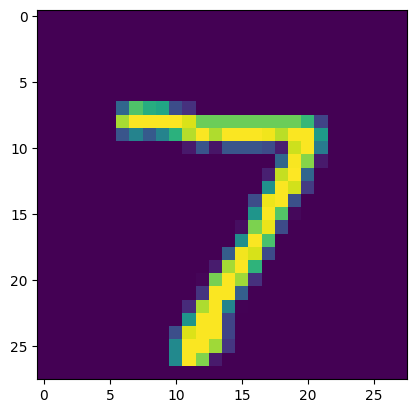

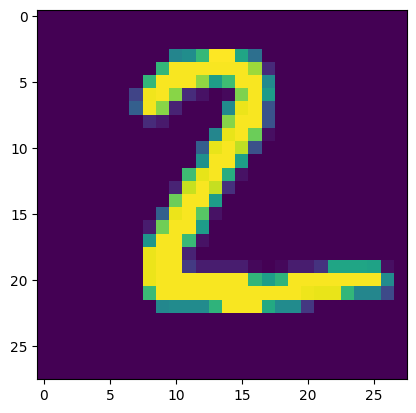

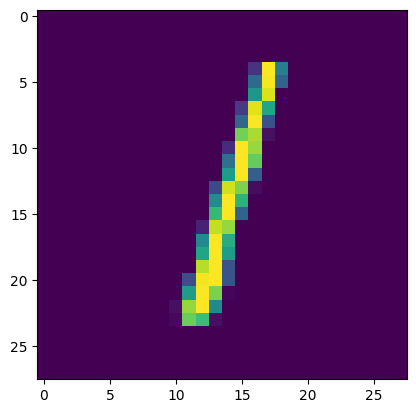

In [36]:
show_images(x)

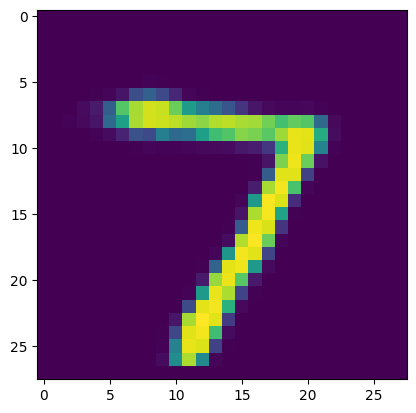

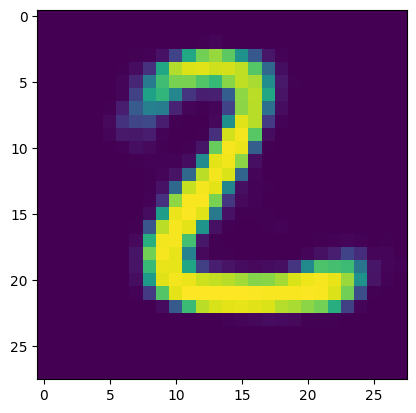

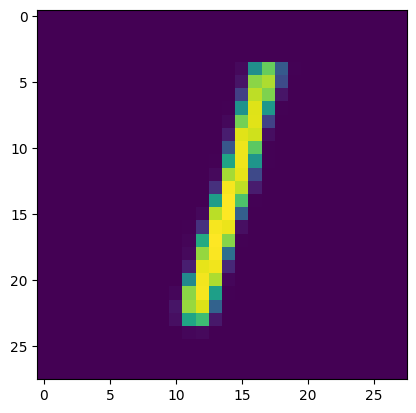

In [37]:
show_images(x_hat)

In [41]:
# TODO: sample noise, generate new images from noise and show generted images
import matplotlib.pyplot as plt

def generate_images(model, num_images=10, device='cuda'):
    with torch.no_grad():
        noise = torch.randn(num_images, 200).to(device)
        generated_images = model.Decoder(noise)
    return generated_images

def show_generated_images(generated_images):
    generated_images = generated_images.cpu().detach().numpy()
    grid = torchvision.utils.make_grid(generated_images, nrow=200, normalize=True)
    plt.figure(figsize=(10, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

generated_images = generate_images(model)
show_generated_images(generated_images)

TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>